In [1]:
from osgeo import gdal
import os
import glob
from contextlib import contextmanager
import rasterio
import numpy as np
@contextmanager
def cwd(path: str) -> None:
    
    """
    Context manager para mudar o diretório de trabalho.
    Mantém o diretório original após a execução do bloco de código.
    """
    
    oldpwd = os.getcwd()
    os.chdir(path)
    try:
        yield
    finally:
        os.chdir(oldpwd)

## Adquirir imagens Awa

In [2]:
with cwd('../Imagens/awa'):
    imagens = sorted(os.listdir())
    caminho = os.path.join(imagens[1], 'GRANULE')
    with cwd(caminho):
        l1c = os.listdir()[0] # Escolher apenas a primeira imagem
        with cwd(os.path.join(l1c, 'IMG_DATA')):
            bandas = sorted(os.listdir())
            banda_b = rasterio.open([b for b in bandas if 'B02' in b][0]).read(1)  # Blue
            banda_g = rasterio.open([b for b in bandas if 'B03' in b][0]).read(1)  # Green
            banda_r = rasterio.open([b for b in bandas if 'B04' in b][0]).read(1)  # Red

In [3]:
def normalize_band(band):
    #band = (band + 1000) / 10000
    #band = band.clip(min=0)
    
    return (band - band.min()) / (band.max() - band.min())

b_r = normalize_band(banda_r)
b_g = normalize_band(banda_g)
b_b = normalize_band(banda_b)

rgb_composite_raw= (np.dstack((b_r, b_g, b_b)) * 3.5).clip(0, 1)
del b_r, b_g, b_b, banda_r, banda_g, banda_b

In [4]:
from skimage.util.shape import view_as_windows

patch_size = 256
step = 128
patches = view_as_windows(rgb_composite_raw, (patch_size, patch_size, 3), step=step)
patches = patches.reshape(-1, patch_size, patch_size, 3)
del rgb_composite_raw

In [5]:
output_dir = 'patches_npy'
os.makedirs(output_dir, exist_ok=True)
for i, patch in enumerate(patches):
    np.save(f'{output_dir}/patch_{i}.npy', patch)

# Testes

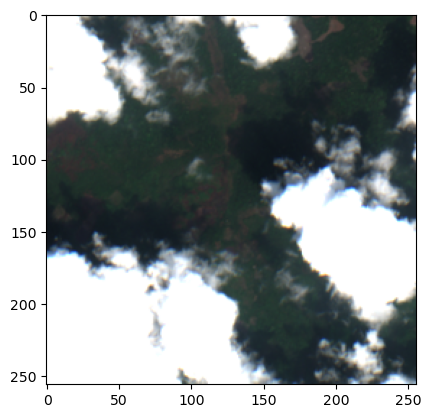

In [2]:
import matplotlib.pyplot as plt

patch_path = 'patches_npy/patch_2.npy'
patch = np.load(patch_path)

plt.imshow(patch)

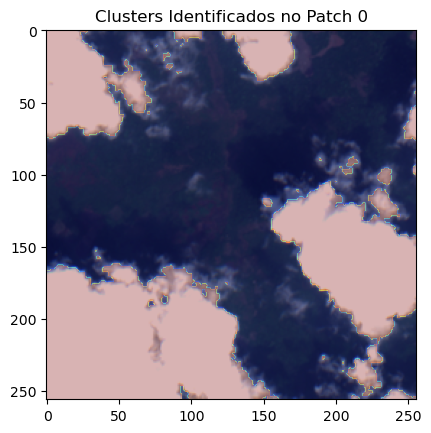

In [7]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# Redimensionar o patch para um array 2D onde cada pixel é uma amostra com 3 atributos (RGB)
pixels = patch.reshape(-1, 3)

# Aplicar K-Means com 2 clusters (por exemplo: nuvens e não nuvens)
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(pixels)

# Rotular cada pixel com seu cluster correspondente
labels = kmeans.labels_

# Reshape dos labels para a dimensão original da imagem
labels_reshaped = labels.reshape(patch.shape[:2])

# Plotar o resultado da clusterização
plt.imshow(patch)
plt.imshow(labels_reshaped, cmap='jet', alpha=0.3)
plt.title("Clusters Identificados no Patch 0")
plt.show()

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn.functional as F


class CloudDataset(Dataset):
    def __init__(self, patches_dir):
        self.patches_dir = patches_dir
        self.patches = glob.glob(f'{patches_dir}/*.npy')
        self.transform = transforms.Compose([
            transforms.ToTensor()  # Apenas para patches de imagem
        ])
    
    def __len__(self):
        return len(self.patches)
    
    def __getitem__(self, idx):
        patch_path = self.patches[idx]
        patch = np.load(patch_path)

        # Aplicar K-Means
        pixels = patch.reshape(-1, 3)
        n_clusters = 2
        kmeans = KMeans(n_clusters=n_clusters, random_state=0)
        kmeans.fit(pixels)
        labels = kmeans.labels_
        target = labels.reshape(patch.shape[:2])

        # Transformar as imagens
        patch = self.transform(patch).float()
        target = torch.tensor(target, dtype=torch.long)  # Convertendo para tensor PyTorch

        return patch, target

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.encoder2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.encoder3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.encoder4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.middle = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )

        self.upconv4 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder4 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.upconv2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.decoder2 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.upconv1 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.decoder1 = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size=1, stride=1, padding=0),
        )
    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))


        middle = self.middle(self.pool4(enc4))

        decoder4 = self.upconv4(middle)
        decoder4 = self.decoder4(torch.cat((enc4, decoder4), 1))

        decoder3 = self.upconv3(decoder4)
        decoder3 = self.decoder3(torch.cat((enc3, decoder3), 1))

        decoder2 = self.upconv2(decoder3)
        decoder2 = self.decoder2(torch.cat((enc2, decoder2), 1))

        decoder1 = self.upconv1(decoder2)
        decoder1 = self.decoder1(torch.cat((enc1, decoder1), 1))

        final_mask = F.sigmoid(decoder1)

        return final_mask


In [4]:
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

# Function to compute accuracy
def compute_accuracy(preds, targets):
    _, predicted = torch.max(preds, 1)
    correct = (predicted == targets).float().sum()
    accuracy = correct / targets.numel()
    return accuracy.item()

def visualize_output(inputs, targets, outputs, idx=0):
    """
    Visualiza a imagem real, a predição do modelo e o mapa de cores.
    """
    input_image = inputs[idx].cpu().numpy().transpose(1, 2, 0)
    target_image = targets[idx].cpu().numpy()
    output_image = outputs[idx].cpu().detach().numpy()

    plt.figure(figsize=(12, 4))

    # Mostrar imagem real
    plt.subplot(1, 3, 1)
    plt.imshow(input_image)
    plt.title('Imagem Real')
    plt.axis('off')

    # Mostrar alvo real
    plt.subplot(1, 3, 2)
    plt.imshow(target_image, cmap='gray')
    plt.title('Alvo Real')
    plt.axis('off')

    # Mostrar predição do modelo
    plt.subplot(1, 3, 3)
    plt.imshow(output_image[0], cmap='gray')
    plt.title('Predição do Modelo')
    plt.axis('off')

    plt.show()


dataset = CloudDataset('patches_npy')
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
model = UNet()

In [5]:
# Definição do dataset
dataset = CloudDataset(patches_dir='patches_npy')
# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

Epoch [1/10]
Train Loss: 0.6006, Train Accuracy: 2.6282
Val Loss: 0.5795, Val Accuracy: 2.6442


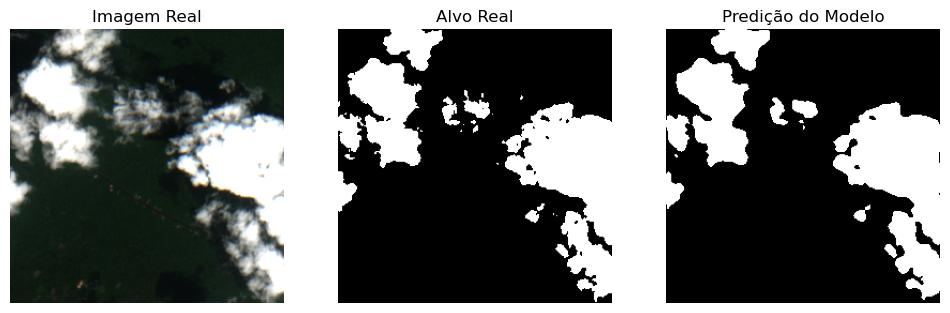

In [10]:
# Model, Loss Function, and Optimizer
model = UNet()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training and Validation Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0.0
    
    for patches, targets in train_loader:
        optimizer.zero_grad()
        
        outputs = model(patches)
        loss = criterion(outputs, targets.float().unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_accuracy += compute_accuracy((outputs > 0.5).float(), targets.float().unsqueeze(1))

    # Validation
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    
    with torch.no_grad():
        for patches, targets in val_loader:
            outputs = model(patches)
            loss = criterion(outputs, targets.float().unsqueeze(1))
            
            val_loss += loss.item()
            val_accuracy += compute_accuracy((outputs > 0.5).float(), targets.float().unsqueeze(1))

    # Print statistics
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy/len(train_loader):.4f}')
    print(f'Val Loss: {val_loss/len(val_loader):.4f}, Val Accuracy: {val_accuracy/len(val_loader):.4f}')

    # Visualizar exemplo de validação
    if (epoch + 1) % 1 == 0:  # Visualizar em cada época
        inputs, targets = next(iter(val_loader))  # Obtém um lote de dados de validação
        with torch.no_grad():
            outputs = model(inputs)
            outputs = (outputs > 0.5).float()
        visualize_output(inputs, targets, outputs, idx=0)  # Visualizar o primeiro exemplo do lote

# Save the trained model
torch.save(model.state_dict(), 'unet_model.pth')

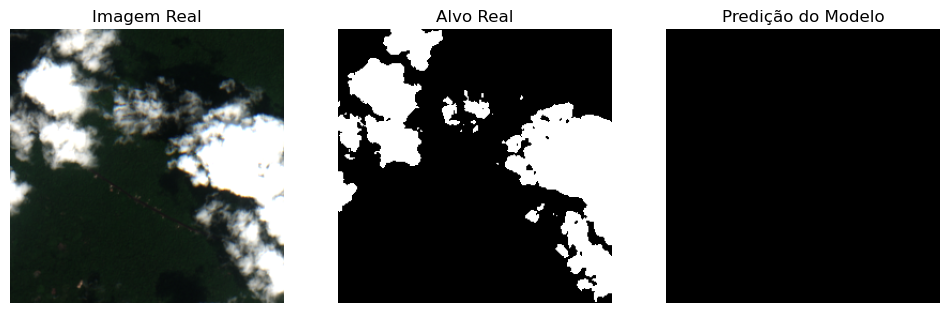

In [8]:
inputs, targets = next(iter(val_loader))  # Obtém um lote de dados de validação
with torch.no_grad():
    outputs = model(inputs)
    outputs = (outputs > 0.5).float()
visualize_output(inputs, targets, outputs, idx=0)  # Visualizar o primeiro exemplo do lote

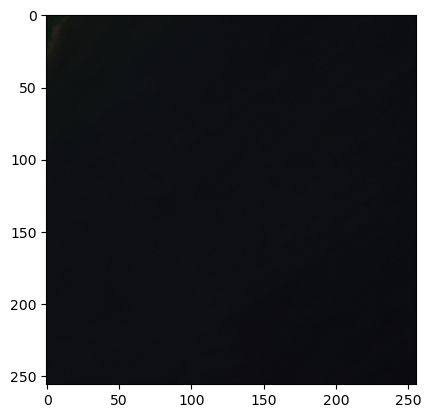

In [96]:
plt.imshow(inputs[0].permute(2, 1, 0).squeeze().numpy())

In [71]:
outputs.shape,inputs.shape

(torch.Size([4, 1, 256, 256]), torch.Size([4, 3, 256, 256]))